In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from csnl import DataGeneratorWithLabels, DataGenerator, DenseLadderVAE, \
DenseLinLinLadderVAE, VAEPlotter, ModelTrainer

Using TensorFlow backend.


In [2]:
norm = False

data_gen_labels = DataGeneratorWithLabels(image_shape=(28, 28, 1),
                                          batch_size=5000,
                                          file_path=os.getcwd() +
                                          '/csnl/data/textures_42000_28px.pkl',
                                          whiten=False,
                                          contrast_normalize=norm)

data_gen = DataGenerator(image_shape=(28, 28, 1),
                         batch_size=5000,
                         file_path=os.getcwd() +
                         '/csnl/data/textures_42000_28px.pkl',
                         whiten=False,
                         contrast_normalize=norm)

Training size : 37800 	 Test size : 4200
Shapes :  (37800, 28, 28, 1) 	 (4200, 28, 28, 1)
Label shaped :  (37800,) 	 (4200,)
Train set : 
Mean: 0.499, Standard Deviation: 0.157
Min: 0.000, Max: 1.000
Test set : 
Mean: 0.499, Standard Deviation: 0.157
Min: 0.000, Max: 1.000
Train SHAPE :  (37800, 28, 28, 1)
/home/qbeer666/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/qbeer666/.local/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/qbeer666/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/qbeer666/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/qbeer666/.local/lib/pyth

In [3]:
LATENT_DIM1 = 16 * 8
LATENT_DIM2 = 8

vae = DenseLinLinLadderVAE(input_shape=(5000, 28*28),
                    latent_dim1=LATENT_DIM1,
                    latent_dim2=LATENT_DIM2)

In [4]:
trainer = ModelTrainer(vae,
                       data_gen,
                       loss_fn="normal",
                       lr=5e-4,
                       decay=1e-4,
                       beta=1)

W1213 10:45:52.371533 140284757452544 deprecation_wrapper.py:119] From /home/qbeer666/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1213 10:45:52.399027 140284757452544 deprecation_wrapper.py:119] From /home/qbeer666/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1213 10:45:52.404485 140284757452544 deprecation_wrapper.py:119] From /home/qbeer666/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1213 10:45:52.724231 140284757452544 deprecation_wrapper.py:119] From /home/qbeer666/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1213 10:

In [34]:
trainer.model.load_weights('./test_runs/14_DenseLinLinLadderVAE_noContrastNorm_/model.h5')
trainer.generator.load_weights('./test_runs/14_DenseLinLinLadderVAE_noContrastNorm_/generator_model.h5')
trainer.latent_model.load_weights('./test_runs/14_DenseLinLinLadderVAE_noContrastNorm_/latent_model.h5')

In [35]:
images, labels = next(data_gen_labels.flow())
recos, z1, _, _, z2, _, _, _, _ = trainer.latent_model.predict(images.reshape(5000, -1), batch_size=5000)

recos = recos.reshape(5000, 28, 28)

In [36]:
import umap

reducer = umap.UMAP()

transformed = reducer.fit_transform(z1)

/home/qbeer666/.local/lib/python3.5/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.local/lib/python3.5/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


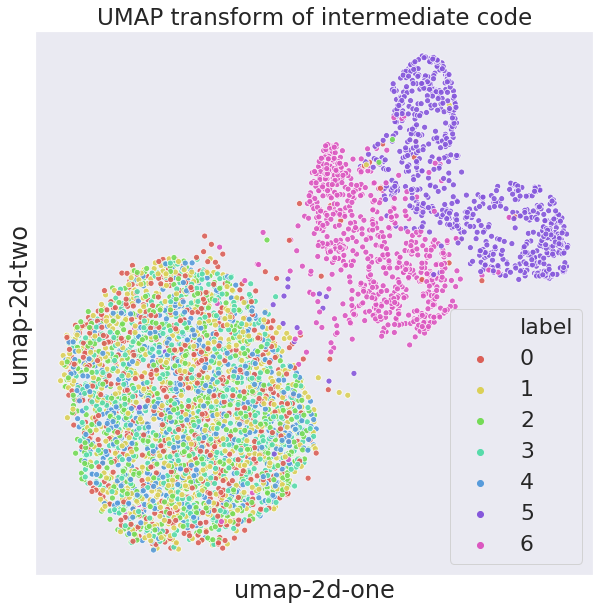

In [37]:
import pandas as pd

df_subset = pd.DataFrame()

df_subset['umap-2d-one'] = transformed[:,0]
df_subset['umap-2d-two'] = transformed[:,1]
df_subset['label'] = labels

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(10, 10))
plt.title('UMAP transform of intermediate code', fontsize=23)

# Bigger than normal fonts
sns.set(font_scale=2)

sns.scatterplot(
    x="umap-2d-one", y="umap-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.9
)

plt.xticks([])
plt.yticks([])

plt.savefig('umap_z1_dense_lin_lin_no_norm.png')

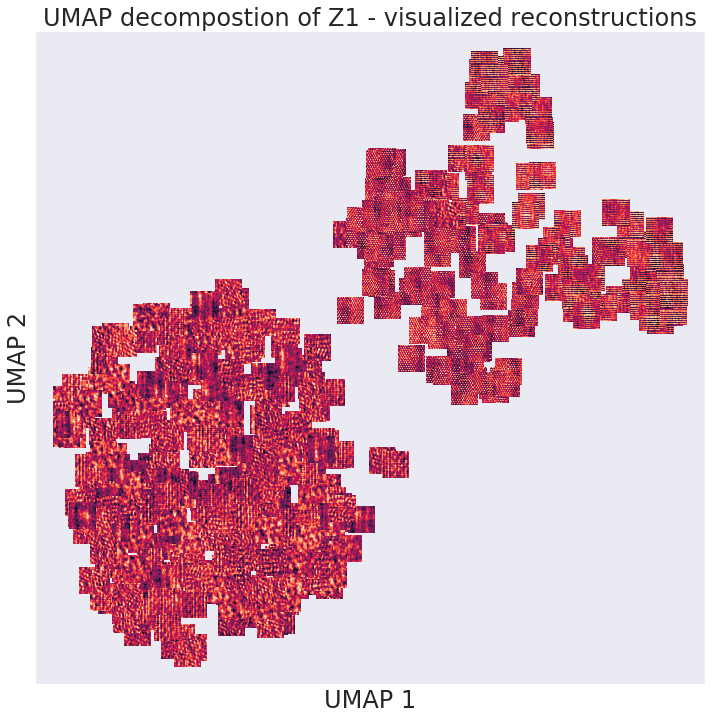

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

size_reduction = 10

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(transformed[:, 0][::size_reduction], transformed[:, 1][::size_reduction]) 

artists = []
for x, y, image in zip(transformed[:, 0][::size_reduction], transformed[:, 1][::size_reduction], recos[::size_reduction]):
    ab = AnnotationBbox(OffsetImage(image, zoom=0.95, interpolation=None), (x, y), frameon=False)
    artists.append(ax.add_artist(ab))
    
plt.xticks([])
plt.yticks([])
plt.title("UMAP decompostion of Z1 - visualized reconstructions")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('umap_z1_dense_lin_lin_no_norm_textures.png')
plt.show()

In [39]:
reducer = umap.UMAP()

transformed = reducer.fit_transform(z2)

/home/qbeer666/.local/lib/python3.5/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.local/lib/python3.5/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [40]:
df_subset = pd.DataFrame()

df_subset['umap-2d-one'] = transformed[:,0]
df_subset['umap-2d-two'] = transformed[:,1]
df_subset['label'] = labels

plt.figure(figsize=(10, 10))
plt.title('UMAP transform of deepest code', fontsize=23)

# Bigger than normal fonts
sns.set(font_scale=2)

sns.scatterplot(
    x="umap-2d-one", y="umap-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.9
)

plt.xticks([])
plt.yticks([])

plt.savefig('umap_z2_dense_lin_lin_no_norm.png')

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

size_reduction = 10

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(transformed[:, 0][::size_reduction], transformed[:, 1][::size_reduction]) 

artists = []
for x, y, image in zip(transformed[:, 0][::size_reduction], transformed[:, 1][::size_reduction], recos[::size_reduction]):
    ab = AnnotationBbox(OffsetImage(image, zoom=0.95, interpolation=None), (x, y), frameon=False)
    artists.append(ax.add_artist(ab))
    
plt.xticks([])
plt.yticks([])
plt.title("TSNE decompostion of Z2 - visualized reconstructions")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('umap_z2_dense_lin_lin_no_norm_textures.png')
plt.show()